In [1]:
!pip install torch torchvision torchaudio
!pip install datasets transformers
!pip install g2p_en praatio librosa

     |████████████████████████████████| 1.9 MB 22.8 MB/s 
     |████████████████████████████████| 1.9 MB 18.6 MB/s 
     |████████████████████████████████| 270 kB 26.1 MB/s 
     |████████████████████████████████| 2.9 MB 38.1 MB/s 
     |████████████████████████████████| 1.3 MB 45.4 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 243 kB 43.7 MB/s 
     |████████████████████████████████| 125 kB 57.3 MB/s 
     |████████████████████████████████| 3.3 MB 42.8 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 636 kB 26.1 MB/s 
     |████████████████████████████████| 271 kB 65.4 MB/s 
     |████████████████████████████████| 160 kB 68.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 3.1 MB 26.4 MB/s 
     |████████████████████████████████| 7

In [2]:
import os
from os.path import exists, join, expanduser

os.chdir(expanduser("~"))
charsiu_dir = 'charsiu'
if exists(charsiu_dir):
  !rm -rf /root/charsiu
if not exists(charsiu_dir):
  ! git clone -b development https://github.com/lingjzhu/$charsiu_dir
  ! cd charsiu && git checkout && cd -
  
os.chdir(charsiu_dir)    

Cloning into 'charsiu'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 181 (delta 72), reused 107 (delta 27), pack-reused 0
Receiving objects: 100% (181/181), 73.41 KiB | 9.18 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Your branch is up to date with 'origin/development'.
/root


In [12]:
import sys
import torch
from itertools import groupby
from datasets import load_dataset
import matplotlib.pyplot as plt

sys.path.insert(0,'src')
from transformers import Wav2Vec2ForCTC
from models import Wav2Vec2ForAttentionAlignment, Wav2Vec2ForFrameClassification
from utils import get_phones, get_phone_ids,audio_preprocess,seq2duration,mapping_id2phone,processor


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# download timit
timit = load_dataset('timit_asr')

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/bce749dca50ede2d9692e53bf7eede501996e25b8aa318280ec9041a9f4c3057. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Phone recognizer + Neural Forced Alignment

In [6]:
# load model
phone_recognizer = Wav2Vec2ForCTC.from_pretrained('charsiu/en_w2v2_ctc_libris_and_cv').to(device).eval()
model = Wav2Vec2ForAttentionAlignment.from_pretrained('charsiu/en_w2v2_fs_10ms').to(device).eval()

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/2.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/387M [00:00<?, ?B/s]

In [17]:
sample = timit['train'][1]
audio = audio_preprocess(sample['file'])

with torch.no_grad():
    out = phone_recognizer(torch.tensor(audio).float().unsqueeze(0).to(device))
pred_ids = torch.argmax(out.logits,dim=-1).squeeze()
phones = processor.tokenizer.convert_ids_to_tokens(pred_ids,skip_special_tokens=True)
phones = [p for p,group in groupby(phones)]
phone_ids = get_phone_ids(phones)

print('True transcription:%s'%(sample['phonetic_detail']['utterance']))
print('Predicted transcription:%s'% (phones))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


True transcription:['h#', 'd', 'ow', 'nx', 'ae', 's', 'epi', 'm', 'iy', 'dx', 'ix', 'kcl', 'k', 'ih', 'r', 'iy', 'eh', 'nx', 'ao', 'l', 'iy', 'r', 'ae', 'gcl', 'g', 'l', 'ah', 'kcl', 'dh', 'ae', 'tcl', 'h#']
Predicted transcription:['[SIL]', 'D', 'OW', 'N', 'AE', 'S', 'K', 'M', 'IY', 'T', 'UW', 'K', 'AE', 'R', 'IY', 'AH', 'N', 'D', 'AO', 'L', 'IY', 'R', 'AE', 'G', 'L', 'AY', 'K', 'DH', 'AE', 'T', '[SIL]']


In [18]:

batch = {'input_values':torch.tensor(audio).float().unsqueeze(0).to(device),
         'attention_mask': torch.ones(1,len(audio)),
         'labels': torch.tensor(phone_ids).unsqueeze(0).long().to(device),
         'labels_attention_mask':torch.ones(1,len(phone_ids)).to(device),
         'text_len':torch.tensor([len(phone_ids)]).to(device)
        }

with torch.no_grad():
  out = model(**batch)
att = torch.softmax(out.logits,dim=-1),

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


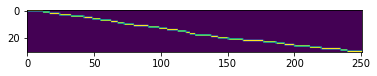

In [19]:
plt.imshow(att[0].squeeze().cpu().detach().transpose(1,0).numpy())

In [20]:
preds = torch.argmax(att[0],dim=-1).cpu().detach().squeeze().numpy()
pred_phones = [mapping_id2phone[phone_ids[i]] for i in preds]
print(seq2duration(pred_phones,resolution=0.01))
print('\\n Ground Truth \\n')
print([(s/16000,e/16000,p) for s,e,p in zip(sample['phonetic_detail']['start'],sample['phonetic_detail']['stop'],sample['phonetic_detail']['utterance'])])

[(0.0, 0.12, '[SIL]'), (0.12, 0.17, 'D'), (0.17, 0.24, 'OW'), (0.24, 0.33, 'N'), (0.33, 0.43, 'AE'), (0.43, 0.49, 'S'), (0.49, 0.55, 'K'), (0.55, 0.63, 'M'), (0.63, 0.68, 'IY'), (0.68, 0.73, 'T'), (0.73, 0.8, 'UW'), (0.8, 0.91, 'K'), (0.91, 0.99, 'AE'), (0.99, 1.05, 'R'), (1.05, 1.13, 'IY'), (1.13, 1.19, 'AH'), (1.19, 1.22, 'N'), (1.22, 1.26, 'D'), (1.26, 1.38, 'AO'), (1.38, 1.43, 'L'), (1.43, 1.51, 'IY'), (1.51, 1.62, 'R'), (1.62, 1.77, 'AE'), (1.77, 1.87, 'G'), (1.87, 1.93, 'L'), (1.93, 2.0, 'AY'), (2.0, 2.12, 'K'), (2.12, 2.21, 'DH'), (2.21, 2.35, 'AE'), (2.35, 2.4, 'T'), (2.4, 2.51, '[SIL]')]
\n Ground Truth \n
[(0.0, 0.1325, 'h#'), (0.1325, 0.1625, 'd'), (0.1625, 0.2375, 'ow'), (0.2375, 0.2715, 'nx'), (0.2715, 0.4425, 'ae'), (0.4425, 0.505, 's'), (0.505, 0.5575, 'epi'), (0.5575, 0.6175, 'm'), (0.6175, 0.6775, 'iy'), (0.6775, 0.7075, 'dx'), (0.7075, 0.7675, 'ix'), (0.7675, 0.825, 'kcl'), (0.825, 0.8975, 'k'), (0.8975, 0.9816875, 'ih'), (0.9816875, 1.01825, 'r'), (1.01825, 1.1305, '

Direct inference with frame classification model

In [21]:
model = Wav2Vec2ForFrameClassification.from_pretrained('charsiu/en_w2v2_fc_10ms').eval().to(device)

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

In [22]:
sample = timit['train'][1]
phones = get_phones(sample['text'])
print('Text transcription:%s'%(sample['text']))
print('Phone transcription: %s'%phones)

Text transcription:Don't ask me to carry an oily rag like that.
Phone transcription: ['D', 'OW', 'N', 'T', ' ', 'AE', 'S', 'K', ' ', 'M', 'IY', ' ', 'T', 'UW', ' ', 'K', 'AE', 'R', 'IY', ' ', 'AE', 'N', ' ', 'OY', 'L', 'IY', ' ', 'R', 'AE', 'G', ' ', 'L', 'AY', 'K', ' ', 'DH', 'AE', 'T', ' ', '.']


In [23]:
sample_audio = audio_preprocess(sample['file'],sr=16000)
sample_audio = torch.Tensor(sample_audio).unsqueeze(0).to(device)
with torch.no_grad():
    out = model(sample_audio)

In [24]:
pred_ids = torch.argmax(out.logits.squeeze(),dim=-1)
pred_ids = pred_ids.detach().cpu().numpy()
pred_phones = [mapping_id2phone[i] for i in pred_ids]
print(seq2duration(pred_phones,resolution=0.01))
print('\\n Ground Truth \\n')
print([(s/16000,e/16000,p) for s,e,p in zip(sample['phonetic_detail']['start'],sample['phonetic_detail']['stop'],sample['phonetic_detail']['utterance'])])

[(0.0, 0.1, '[SIL]'), (0.1, 0.16, 'D'), (0.16, 0.23, 'OW'), (0.23, 0.27, 'N'), (0.27, 0.28, 'M'), (0.28, 0.44, 'AE'), (0.44, 0.51, 'S'), (0.51, 0.54, 'T'), (0.54, 0.63, 'M'), (0.63, 0.67, 'IY'), (0.67, 0.71, 'T'), (0.71, 0.76, 'IH'), (0.76, 0.89, 'K'), (0.89, 0.97, 'EH'), (0.97, 1.05, 'R'), (1.05, 1.12, 'IY'), (1.12, 1.18, 'AH'), (1.18, 1.23, 'N'), (1.23, 1.35, 'OW'), (1.35, 1.43, 'L'), (1.43, 1.49, 'IY'), (1.49, 1.59, 'R'), (1.59, 1.78, 'AE'), (1.78, 1.85, 'G'), (1.85, 1.92, 'L'), (1.92, 1.99, 'AY'), (1.99, 2.12, 'K'), (2.12, 2.19, 'DH'), (2.19, 2.2, 'AH'), (2.2, 2.37, 'AE'), (2.37, 2.41, 'T'), (2.41, 2.51, '[SIL]')]
\n Ground Truth \n
[(0.0, 0.1325, 'h#'), (0.1325, 0.1625, 'd'), (0.1625, 0.2375, 'ow'), (0.2375, 0.2715, 'nx'), (0.2715, 0.4425, 'ae'), (0.4425, 0.505, 's'), (0.505, 0.5575, 'epi'), (0.5575, 0.6175, 'm'), (0.6175, 0.6775, 'iy'), (0.6775, 0.7075, 'dx'), (0.7075, 0.7675, 'ix'), (0.7675, 0.825, 'kcl'), (0.825, 0.8975, 'k'), (0.8975, 0.9816875, 'ih'), (0.9816875, 1.01825, 'r'